### Deep Neural Network
Again, we are going to build a neural net but this time it's going to be a deep neural net with the following structure:
- Nuber of hidden layers (any)
- All hidden layers have **ReLU activation function** and the last layer has a **sigmoid activation function** (probability)

In order to build such netwrok we are going to use **intermediate functions** that will allow buildinng the complete neural net

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_moons

warnings.filterwarnings('ignore')

### Data Generation

In [257]:
x, y = make_moons(n_samples=10000, shuffle=True, noise=0.35, random_state=42)

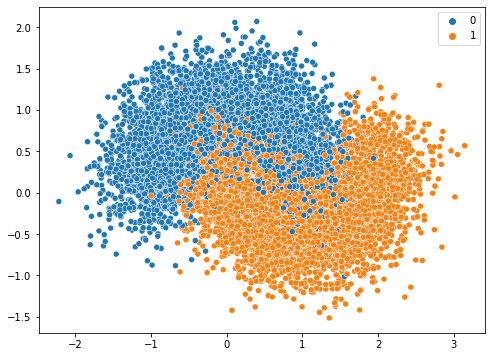

In [258]:
# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x[:,0], x[:,1], hue=y);

The shape in feature space is non linear.

### Data Preprocessing

In [259]:
# Train/Test split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# Required Shape
x_train = x_train.T # (n_features x n_samples)
y_train = y_train[np.newaxis, :] # row-vector

x_test = x_test.T 
y_test = y_test[np.newaxis, :]

### Intermediate Functions
- `initialize_params()` 
- `relu() / relu_derivative()`
- `sigmoid() / sigmoid_derivative()`
- `propagate_forward_single()`
- `propagate_forward_all()`
- `compute_cost()`
- `propagate_back_single()`
- `propagate_back_all()`
- `update_params()`

### Activation Functions 

In [260]:
# Activation Functions
def relu(Z):
    return np.maximum(0.0, Z)

def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

# Derivatives of AF 
def relu_derivative(Z):
    return np.greater(Z, 0).astype(int)

def sigmoid_derivative(Z):
    return sigmoid(Z)*(1 - sigmoid(Z))

### Random Initialization and Forward Propagation 

In [261]:
# Parameters Initialization
def initialize_params(layers_size, seed=42):
    """
    Initializes parameters of a neural net with a small random numbers
    
    Arguments:
    layers_size -  array (list): dimensions of each layer in a network
    
    Returns:
    params - dict: initialized parameters of the neural net 
    
    """
    
    np.random.seed(seed)
    params = {}
    
    for L in range(1, len(layers_size)):
        params[f'W{L}'] = np.random.randn(layers_size[L], layers_size[L-1])*0.01
        params[f'B{L}'] = np.zeros((layers_size[L], 1))
        
        
        # Vectors Shape Check 
        assert(params[f'W{L}'].shape == (layers_size[L], layers_size[L-1]))
        assert(params[f'B{L}'].shape == (layers_size[L], 1))
        
    return params
        
# Forward Propagation For a Single Layer 
def propagate_forward_single(A_prev, W, B, activation='relu'):
    """
    Implements forward propagation for a single layer L
    
    Arguments:
    A_prev - matrix: activations from previous layer (or input data). Required shape: (n_prev, n_examples)
    W - matrix: weigths for a layer L. Required shape: (n_current_neurons, n_prev_neurons)
    B - column-vector: neuron biases. Required shape: (n_current_neurons, 1)
    activation - str: activation function type (sigmoid/ReLU)
    
    Returns:
    A - matrix: activation of a layer L. Required shape (n_current_neurons, n_examples)
    activation_cache - tuple: values needed for backprop
    
    """
    
    if activation == 'relu':
        Z = np.dot(W, A_prev) + B # Don't transpouse W because it already has required shape
        A = relu(Z)
        
        # needed for backprop
        linear_cache = (A_prev, W, B) 
        cache = (linear_cache, Z) # include value Z (activation_cache)
        
        return A, cache
    
    if activation == 'sigmoid':
        Z = np.dot(W, A_prev) + B
        A = sigmoid(Z)
        
        linear_cache = (A_prev, W, B)
        cache = (linear_cache, Z)
        
        return A, cache
    
# Forward Propagation For All Layers
def propagate_forward_all(X, params):
    """
    Implements forward propagation for all layers of a neural net (LINEAR->RELU)*[L-1] -> (LINEAR->SIGMOID)
    
    Arguments:
    X - column-vector: input_data or A_0
    params - dict: initialized parameters of a neural net
    
    Returns:
    Y_hat - row-vector: predicted probabilities for each training example m
    caches - list: all intermediate values needed for backprop 
    
    
    """
    n_layers = len(params)//2 # nuber of layers in a neural net  
    A = X
    caches = [] # caches of each layer

    # Iterate through all hidden layers with ReLU activation function 
    for L in range(1, n_layers):
        A, cache = propagate_forward_single(A_prev=A, W=params[f'W{L}'], B=params[f'B{L}'], activation='relu')
        caches.append(cache)
        
    # The last layer with a sigmoid activation function 
    Y_hat, cache = propagate_forward_single(A_prev=A, W=params[f'W{n_layers}'], B=params[f'B{n_layers}'], activation='sigmoid')
    caches.append(cache)
    
    return Y_hat, caches

# Cost Computation 
def compute_cost(Y_hat, Y):
    """
    Computes the cost function
    
    Arguments:
    Y_hat - row-vector: predicted probabilities for each training example m
    Y - row-vector: ground truth 
    
    Returns:
    cost - row-vector: current cost for all training examples m
    """
    m = Y.shape[1]
    return - np.sum((Y*np.log(Y_hat) + (1 - Y)*np.log(1 - Y_hat)), axis=1, keepdims=True)/m
    

### Backpropagation

In [262]:
def propagate_back_single(dA, cache, activation):
    """
    Computes the gradients for the current layer L
    
    Arguments: 
    dA - 
    cache - list: all intermediate values needed for backprop
    activation - str: type of an activation function 
    
    Returns:
    dW, dB, dA_prev - matrices: the gradients 
    
    """
    # Unpack cache tuple
    linear_cache, activation_cache = cache
    A_prev, W, B = linear_cache
    
    m = dA.shape[1] # number of training examples
    
    if activation == 'sigmoid':
        dZ = dA * sigmoid_derivative(Z=activation_cache)
        
        dW = np.dot(dZ, A_prev.T)/m
        dB = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(W.T, dZ)
        
        return dW, dB, dA_prev
    
    if activation == 'relu':
        dZ = dA * relu_derivative(Z=activation_cache)
        
        dW = np.dot(dZ, A_prev.T)/m
        dB = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(W.T, dZ)
        
        return dW, dB, dA_prev
        
def propagate_back_all(Y_hat, Y, caches):
    """
    Computes the gradietns for all layers 
    
    Arguments:
    Y_hat - row-vector: vector of probabilities
    Y - row-vector: ground truth 
    caches - list: contains tuples of intermediate values needed for backprop for a layer L 
    
    Returns:
    grads - dict: computed gradients 

    """
    grads = {} # gradients 
    L = len(caches) # number of layers 
    m = Y_hat.shape[1] # number of training examples
    Y = Y.reshape(Y_hat.shape) # make sure that predictions and ground truth have the same shape
    
    # Backprop (Sigmoid Part)
    dAL = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat)) # derivative of a loss with respect to A[L] or Y_hat
    current_cache = caches[L-1] # params of the SECOND layer L=1 (because L=0 -> params of the FIRST layer!!!)
    
    # Find the gradients for the layer L and dA for the layer L-1
    dW_temp, dB_temp, dA_prev_temp = propagate_back_single(dA=dAL, cache=current_cache, activation='sigmoid')
    
    # Save the gradients 
    grads[f'dW{L}'] = dW_temp
    grads[f'dB{L}'] = dB_temp
    grads[f'dA{L-1}'] = dA_prev_temp
    
    # Backprop (ReLU Part)
    for l in reversed(range(L-1)):
        current_cache = caches[l] # params of the FIRST layer W1, B1, A0 - X
        dW_temp, dB_temp, dA_prev_temp = propagate_back_single(dA=grads[f'dA{l + 1}'],
                                                               cache=current_cache, activation='relu')
        
        grads[f'dW{l + 1}'] = dW_temp # dW1
        grads[f'dB{l + 1}'] = dB_temp # dB1
        grads[f'dA{l}'] = dA_prev_temp
        
    return grads

### Parameters Update

In [263]:
def update_params(params, grads, learning_rate):
    """
    Update parameters using Gradient Descent
    
    Arguments:
    params - dict: current parameters of the net
    grads - dict: current gradients 
    learning_rate - float: learning rate value 
   
    Returns:
    parameters - dict: updated parameters W and B 
    
    """
    parameters = params.copy()
    L = len(params) // 2 # number of layers 
    
    # Gradient Descent
    for l in range(1, L+1):
        parameters[f'W{l}'] = parameters[f'W{l}']  - learning_rate * grads[f'dW{l}']
        parameters[f'B{l}'] = parameters[f'B{l}']  - learning_rate * grads[f'dB{l}']
        
    return parameters

### Neural Net Model Optimization

In [264]:
def optimize_nn_model(X, Y, layers_dims, learning_rate = 0.02, num_iterations = 300, seed=42, print_cost=False):
    """
    Runs Gradient Descent algorithm (optimizes the weights and biases)
    
    Arguments:
    X - array: feature vector of input data
    Y - array: ground truth
    learning_rate - float: learning rate
    num_iterations - int: number of iteration of Gradient Descent
    seed - int: random seed
    print_cost - bool: wether to print cost or not
    
    Returns:
    parameters - dict: optimized parameters
    costs - list: cost value at each iteration
    
    """
    costs = []
    parameters = initialize_params(layers_size=layers_dims, seed=seed)
    
    for i in range(0, num_iterations):
        Y_hat, caches = propagate_forward_all(X, params=parameters) # Forward Pass
        current_cost = np.squeeze(compute_cost(Y_hat, Y)) # Cost Computation
        grads = propagate_back_all(Y_hat, Y, caches) # Backprop
        parameters = update_params(parameters, grads, learning_rate) # Parameters Update
        
        costs.append(current_cost)
        
        if i % 100 == 0 and print_cost:
            print(f'Iteration {i} Cost: {current_cost}')
            
    return parameters, costs

### Neural Net Prediction

In [265]:
# Predict method 
def predict(params, X, Y):
    """
    Predicts labels for the obtained probabilities
    
    Argumetns:
    params - dict: optimized parameters
    X - array: input data
    Y - array: ground truth 
    
    Returns:
    preds - array: labels
    
    """
    Y_hat, cache = propagate_forward_all(X, params=params) 
    preds = np.where(Y_hat > 0.5, 1, 0)
    
    return preds

### Final Model and Prediction

In [294]:
layers_dims = [x_train.shape[0], 8, 8, 1] # Neural Net Architecture

# Neural Net Optimization
parameters, costs = optimize_nn_model(X=x_train, Y=y_train, layers_dims=layers_dims,
                                      learning_rate = 1.2, num_iterations = 2000, seed=42, print_cost=True)

# Predictions
preds_train = predict(parameters, x_train, y_train)
print('\nTrain Accuracy: ', 1 - np.mean(np.abs(preds_train - y_train)))

preds_test = predict(parameters, x_test, y_test)
print('Test Accuracy: ', 1 - np.mean(np.abs(preds_test - y_test)))

Iteration 0 Cost: 0.6931477022535871
Iteration 100 Cost: 0.6931402841475329
Iteration 200 Cost: 0.693107892163011
Iteration 300 Cost: 0.37099097054738794
Iteration 400 Cost: 0.39165756628665915
Iteration 500 Cost: 0.3671599224423163
Iteration 600 Cost: 0.3645613562964936
Iteration 700 Cost: 0.36016993826440347
Iteration 800 Cost: 0.30926665734373976
Iteration 900 Cost: 0.28182017265685444
Iteration 1000 Cost: 0.27824765011420505
Iteration 1100 Cost: 0.2767263099863254
Iteration 1200 Cost: 0.2746803752492175
Iteration 1300 Cost: 0.2733966300564274
Iteration 1400 Cost: 0.2727115555246216
Iteration 1500 Cost: 0.27139463540870995
Iteration 1600 Cost: 0.27134052054833685
Iteration 1700 Cost: 0.27124838012729613
Iteration 1800 Cost: 0.271088269471783
Iteration 1900 Cost: 0.27062025039113724

Train Accuracy:  0.8835
Test Accuracy:  0.897
